In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging
from experiments.util import lp_metric_dict
import numpy as np
from experiments.dbconnection import DBConnector

Using TensorFlow backend.


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results.log')
setup_logging(log_path=log_path)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc"]

In [3]:
def get_letor_string(dp):
    y =  str(dp['year']) 
    n = str(dp['n_objects'])
    return "y_{}_n_{}".format(y,n)
def get_results_for_dataset(DATASET, del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'masterthesis'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {3} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset=\'{2}\'"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3")
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    columns = list(df_full.columns)
    return df_full, columns

In [4]:
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini
def get_name(name):
    named = dict()
    named["NEAREST_NEIGHBOUR_MEDOID"] = "Nearest Neighbour"
    named["NEAREST_NEIGHBOUR"] = "Most Similar Movie"
    named["DISSIMILAR_NEAREST_NEIGHBOUR"] = "Most Dissimilar Movie"
    named["CRITIQUE_FIT_LESS"] = "Best Critique-Fit Movie d=-1"
    named["CRITIQUE_FIT_MORE"] = "Best Critique-Fit Movie d=+1"
    named["DISSIMILAR_CRITIQUE_LESS"] = "Impostor Critique-Fit Movie d=-1"
    named["DISSIMILAR_CRITIQUE_MORE"] = "Impostor Critique-Fit Movie d=+1"
    named["UNIQUE_MAX_OCCURRING"] = "Mode Least Angle"
    named["SUSHI_DC"] = "SUSHI"
    named["Y_2007_N_10"] = "MQ2007 10 Objects"
    named["Y_2007_N_5"] = "MQ2007 5 Objects"
    named["Y_2008_N_10"] = "MQ2008 10 Objects"
    named["Y_2008_N_5"] = "MQ2008 5 Objects"
    if name not in named.keys():
        named[name] = name.lower().title()
    return named[name]
def create_combined_dfs(DATASET):
    df_full, cols = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df
df = create_combined_dfs(datasets[3])
df.head()

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricalaccuracyse,categoricaltopk2se,categoricaltopk3se,categoricaltopk4se,categoricaltopk5se
0,Y_2007_N_10,GENERALIZED_EXTREME_VALUE,0.295,0.449,0.566,0.667,0.752,0.020,0.019,0.015,0.011,0.007
1,Y_2007_N_10,MIXED_LOGIT_MODEL,0.246,0.380,0.492,0.588,0.679,0.016,0.020,0.018,0.018,0.019
2,Y_2007_N_10,MULTINOMIAL_LOGIT_MODEL,0.287,0.442,0.566,0.668,0.753,0.016,0.015,0.014,0.011,0.008
3,Y_2007_N_10,NESTED_LOGIT_MODEL,0.301,0.458,0.576,0.677,0.758,0.021,0.018,0.017,0.012,0.014
4,Y_2007_N_10,PAIRED_COMBINATORIAL_LOGIT,0.290,0.442,0.564,0.668,0.750,0.020,0.018,0.017,0.012,0.007


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        sub_plot.plot(N_OBJECTS_ARRAY, acc, label='RANDOM', linewidth=1, color='k', marker='H')
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.05))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
def plot_graphs_for_dataset(DATASET):
    plot_file = os.path.join(DIR_PATH, 'thesis', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)

    i = 0
    if len(grouped)in [4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
        print
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[0,1,2]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]]}
    #inds = 
    zoom = False
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        if DATASET =='letor_dc':
            #sharex = True
            a = 2
            b = 2
            size = (15,12)
            zoom = True
        if DATASET =='sushi_dc':
            #sharex = True
            a = 1
            b = 2
            size = (15,6)
            zoom = True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


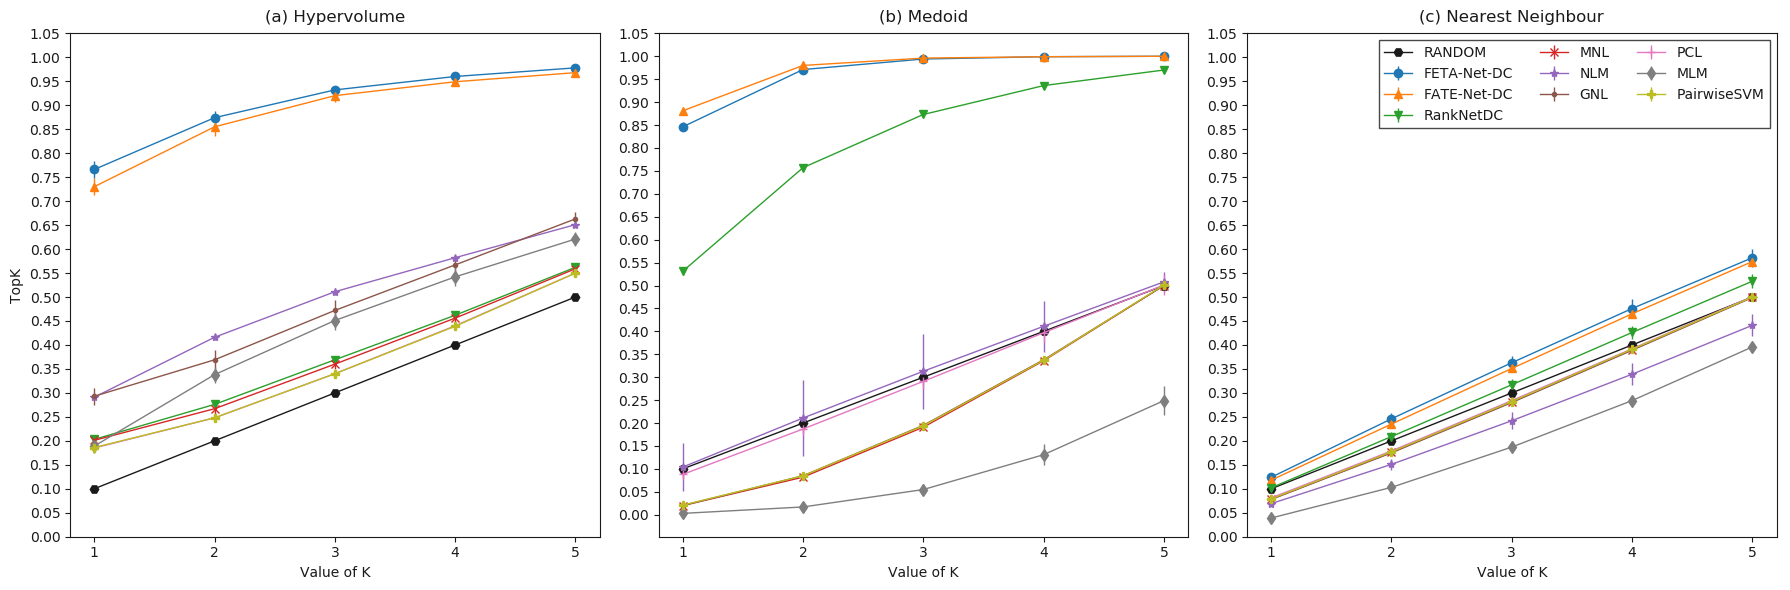

mnist_dc


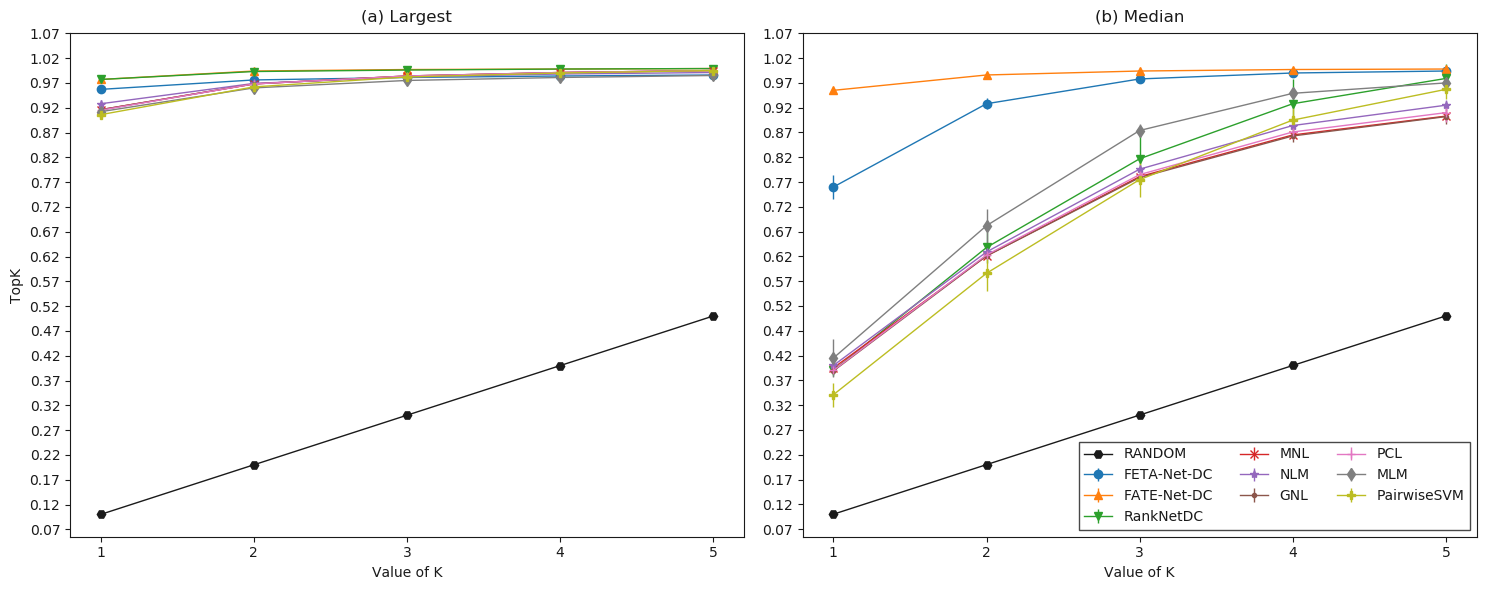

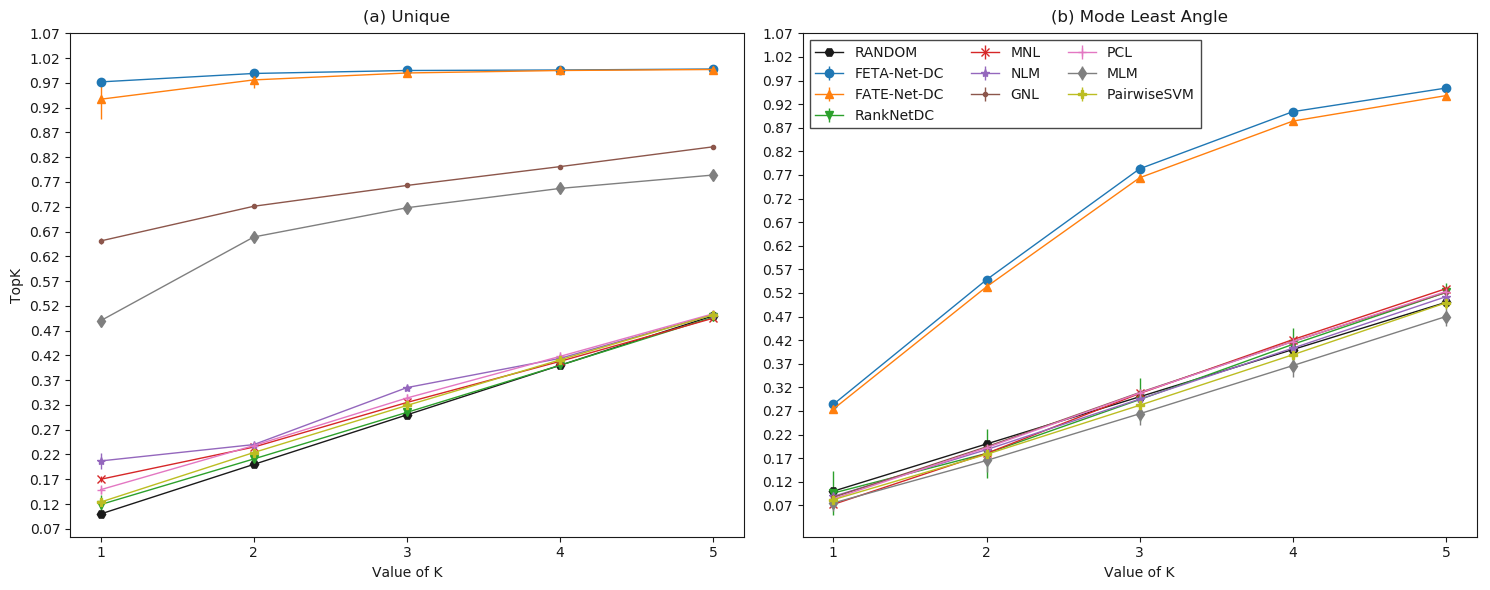

tag_genome_dc


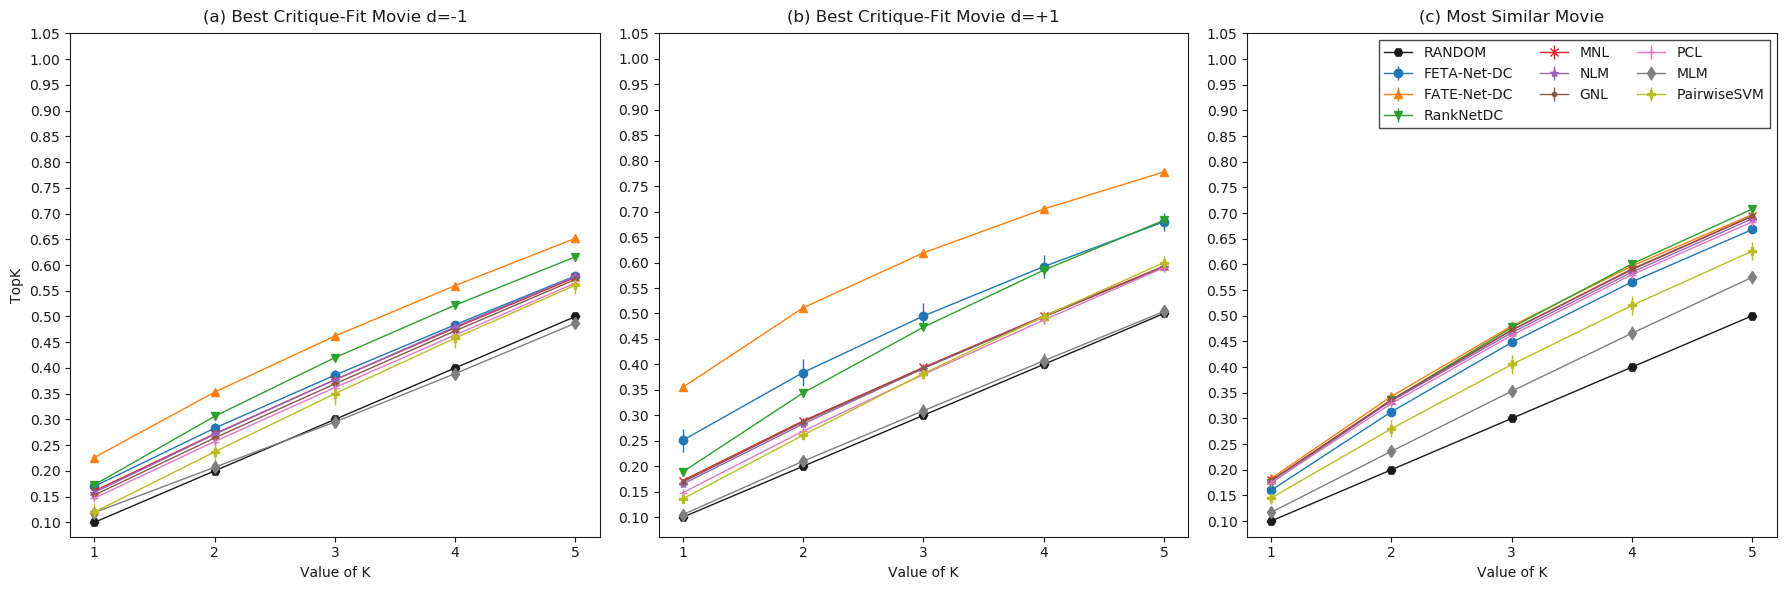

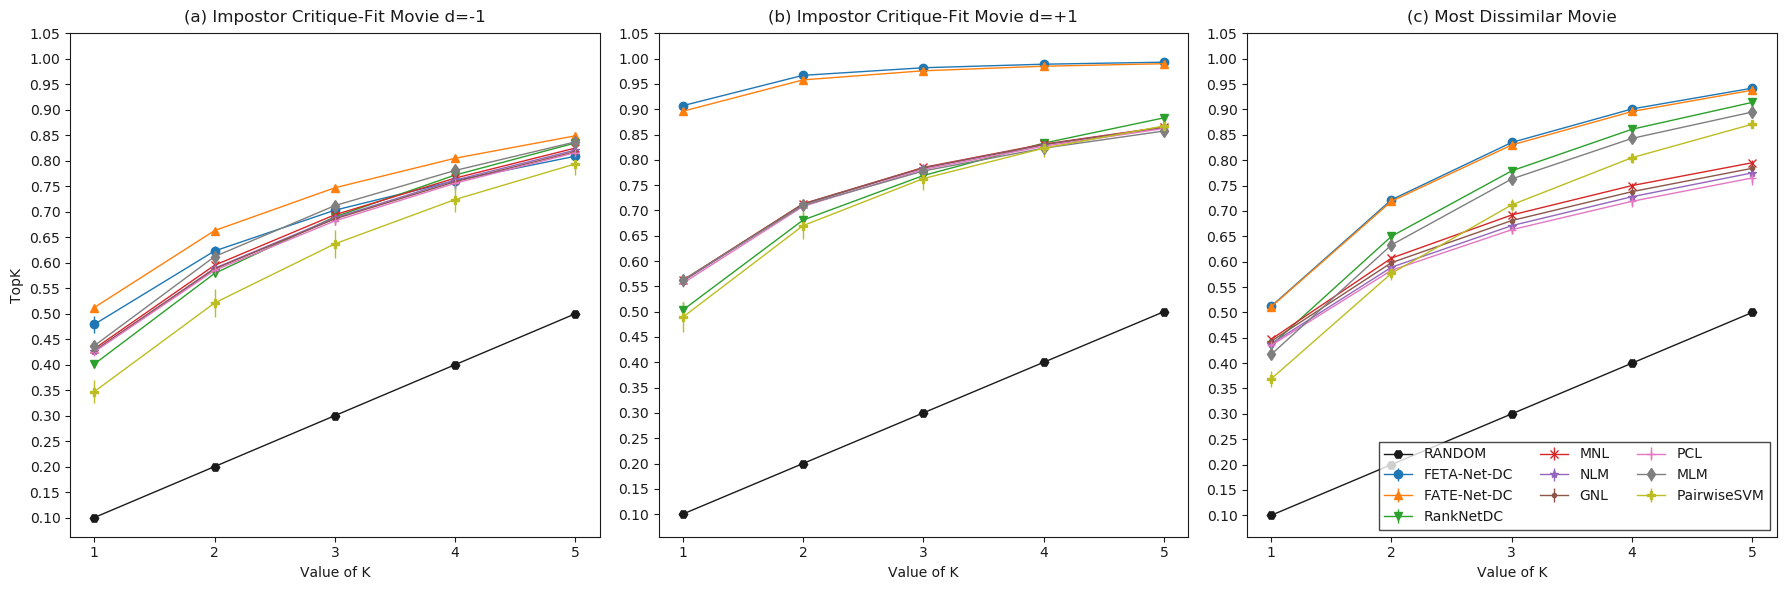

letor_dc


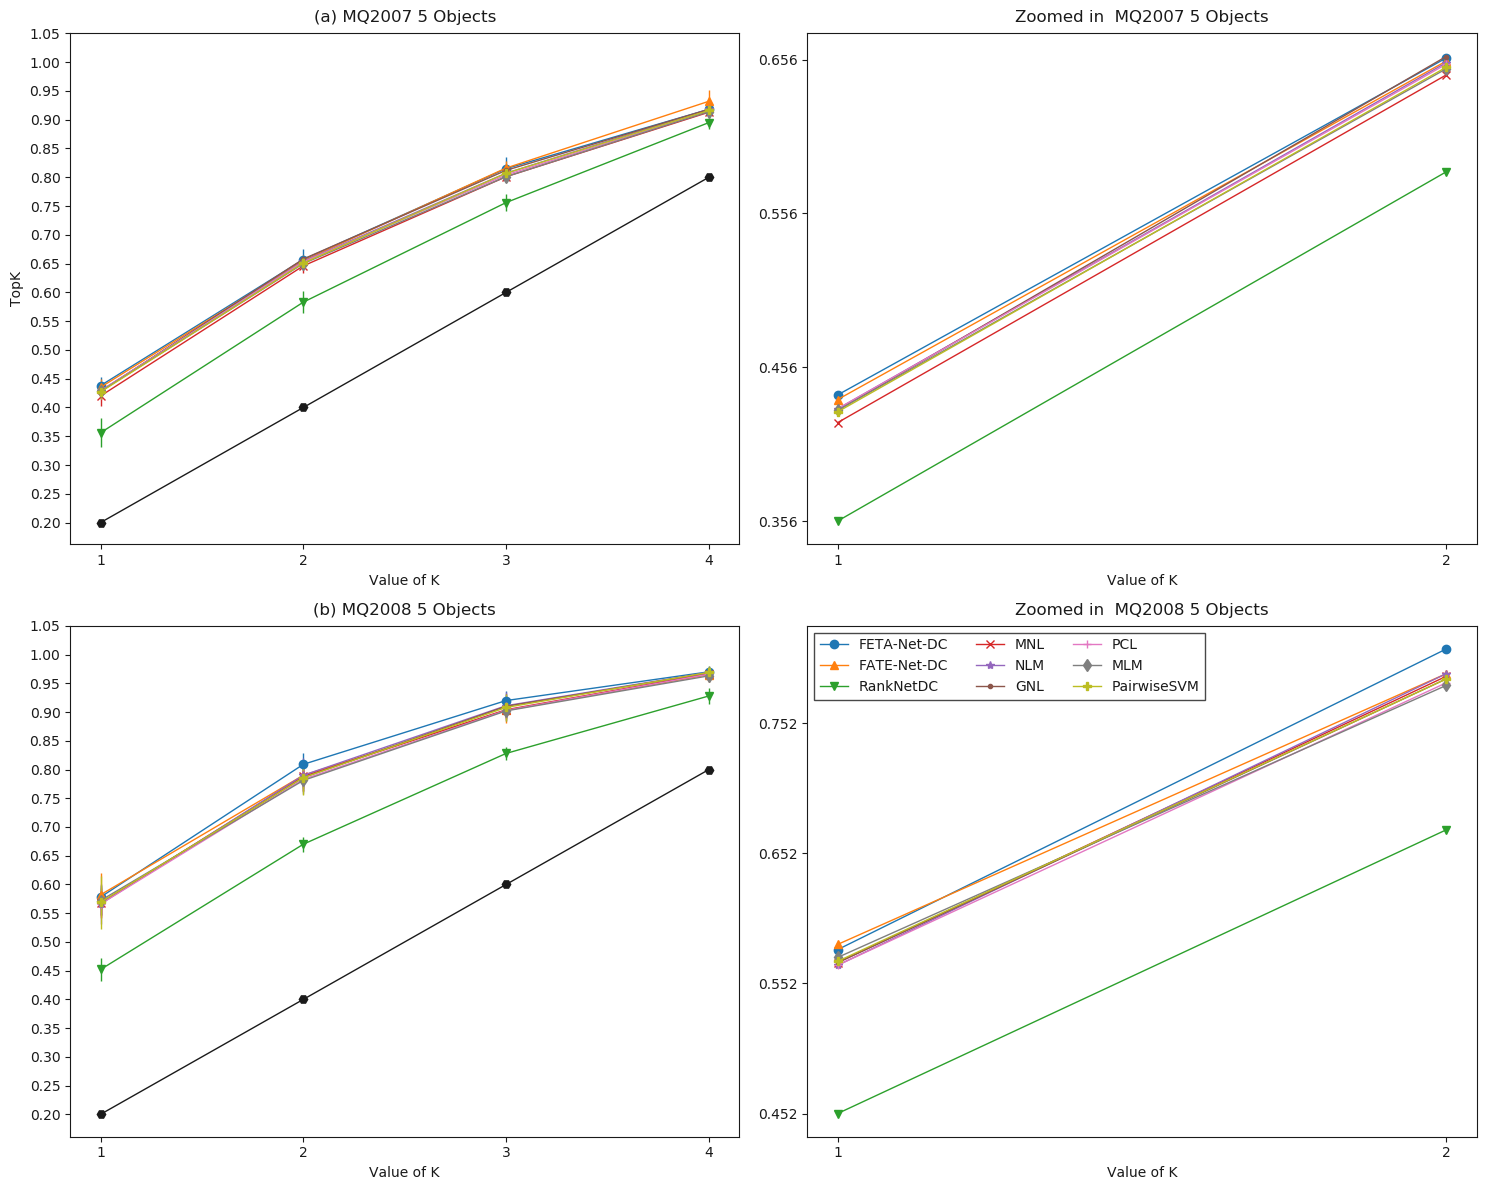

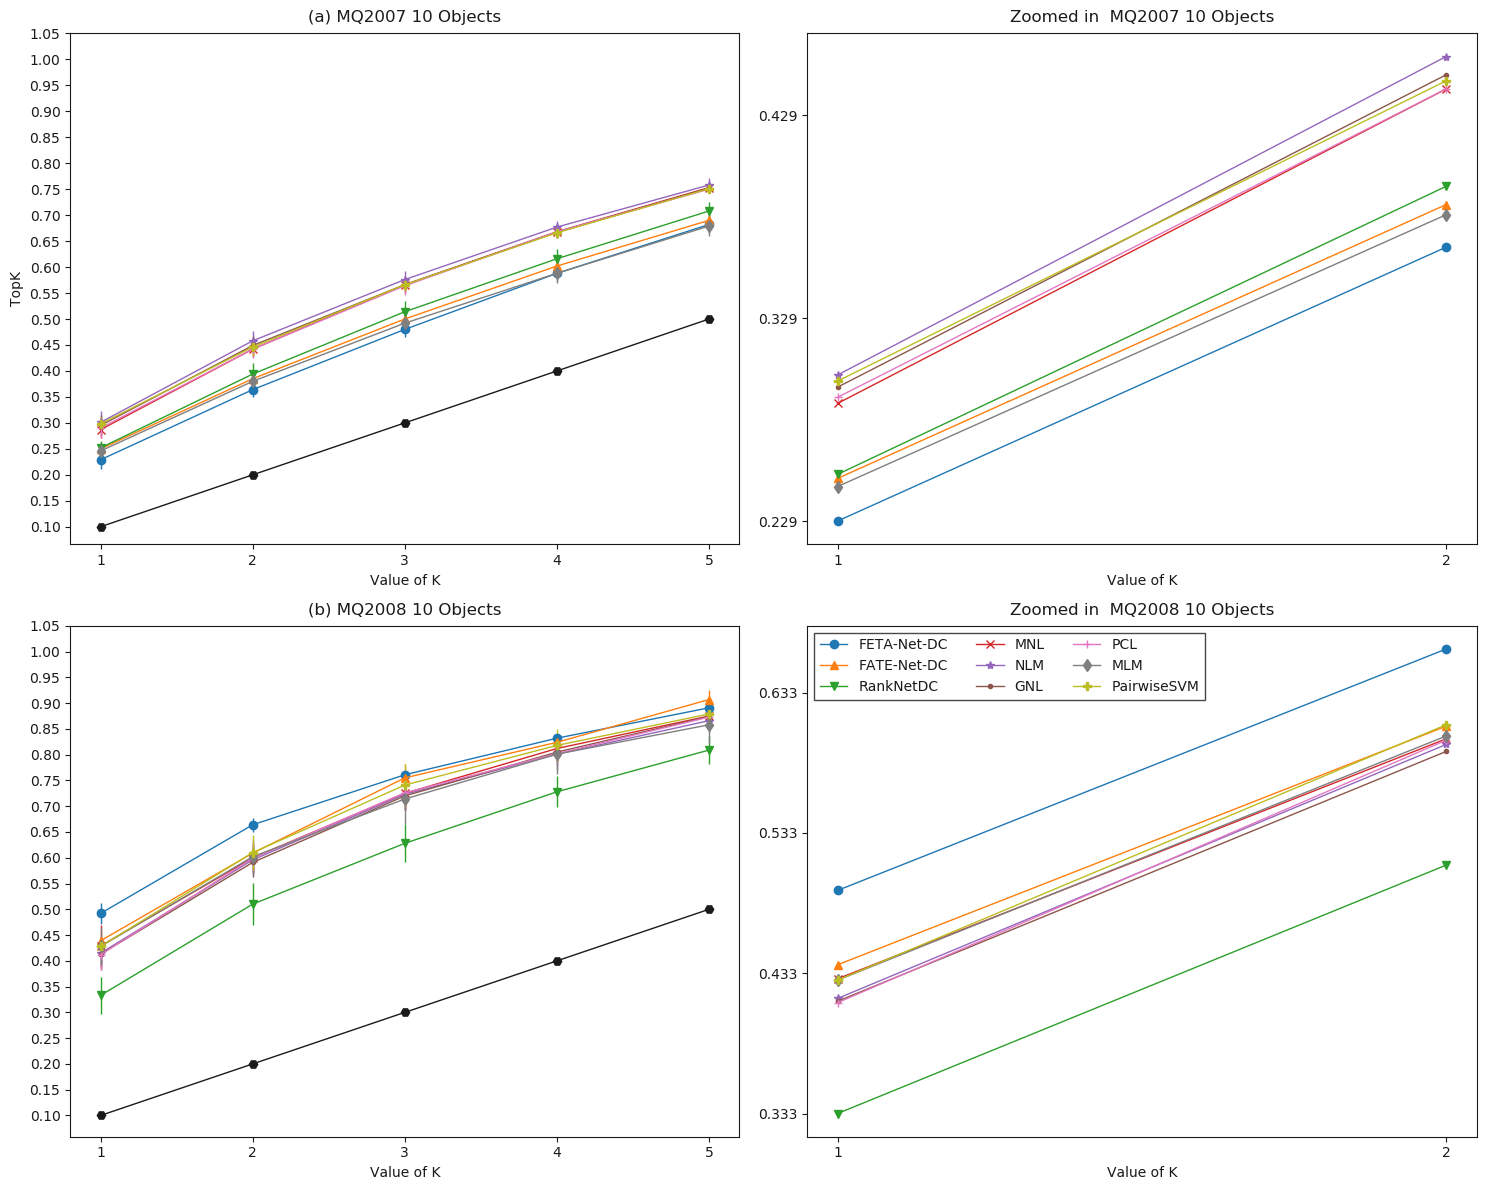

sushi_dc


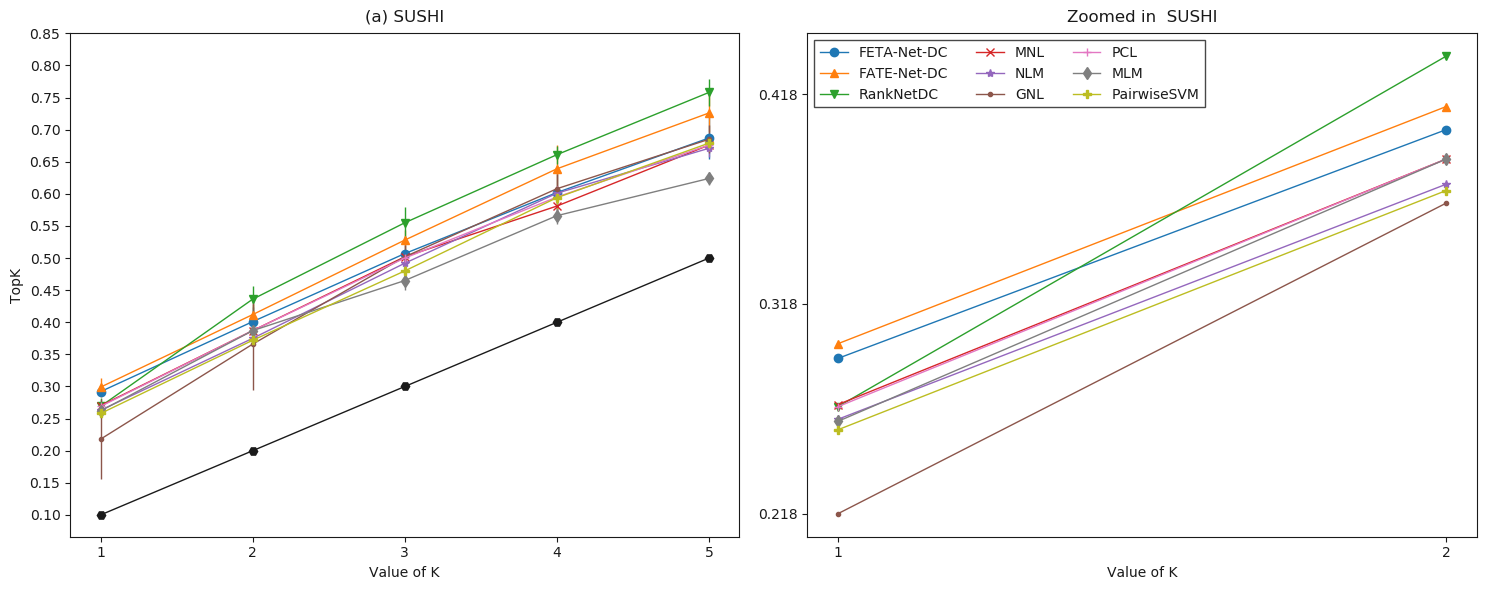

In [8]:
from constants import DCMS
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'MNL', 'NLM', 'GNL', 'PCL', 'MLM', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'pdf','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [7]:
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
schema = 'masterthesis'
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
update_result = "UPDATE results.discrete_choice set cluster_id = %s, CategoricalAccuracy = %s, CategoricalTopK2 = %s, CategoricalTopK3 = %s, CategoricalTopK4 = %s, CategoricalTopK5 = %s, CategoricalTopK6 = %s  where job_id= %s"
values = (6636227, 0.5035, 0.6666, 0.7680, 0.8376, 0.9002, 0.9513, 506)
self.init_connection()
self.cursor_db.execute(update_result, tuple(values))
self.close_connection()

In [8]:
DATASET = datasets[2]
df_full, columns = get_results_for_dataset(DATASET, del_jid=True)
print(columns)
#df_full['zeroonerankaccuracy'] = 1 - df_full['zeroonerankloss']
df = df_full.loc[df_full.learner.str.contains("FETA_DC")].sort_values(['learner', 'dataset'])
#df = df.loc[df.dataset.str.contains("Y_2008")].sort_values(['learner', 'dataset', 'job_id'])
df

['dataset', 'learner', 'categoricalaccuracy', 'categoricaltopk2', 'categoricaltopk3', 'categoricaltopk4', 'categoricaltopk5', 'categoricaltopk6']


,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
125,CRITIQUE_FIT_LESS,FETA_DC,0.1618,0.2739,0.3799,0.4797,0.5764,0.6714
126,CRITIQUE_FIT_LESS,FETA_DC,0.1643,0.2744,0.3770,0.4763,0.5707,0.6631
120,CRITIQUE_FIT_LESS,FETA_DC,0.1735,0.2895,0.3927,0.4914,0.5864,0.6769
122,CRITIQUE_FIT_LESS,FETA_DC,0.1845,0.2972,0.4000,0.4948,0.5880,0.6799
124,CRITIQUE_FIT_LESS,FETA_DC,0.1661,0.2785,0.3811,0.4790,0.5744,0.6670
101,CRITIQUE_FIT_MORE,FETA_DC,0.2656,0.4043,0.5152,0.6093,0.6949,0.7718
100,CRITIQUE_FIT_MORE,FETA_DC,0.2405,0.3698,0.4807,0.5774,0.6689,0.7500
142,CRITIQUE_FIT_MORE,FETA_DC,0.2215,0.3512,0.4638,0.5662,0.6592,0.7443
105,CRITIQUE_FIT_MORE,FETA_DC,0.2483,0.3782,0.4889,0.5888,0.6756,0.7559
107,CRITIQUE_FIT_MORE,FETA_DC,0.2804,0.4184,0.5285,0.6207,0.7038,0.7784


In [9]:
df_full, columns = get_results_for_dataset(DATASET, del_jid=True)
grouped = df_full.groupby(['dataset', 'learner'])
data = []
for name, group in grouped:
    one_row = [name[0], str(name[1]).upper()]
    #latex_row = ["$ {}".format(name[0]), "$ {}".format(str(name[1]).upper())]
    std = group.std(axis=0).values
    mean = group.mean(axis=0).values
    if np.all(np.isnan(std)):
        one_row.extend(["{:.4f}".format(m) for m in mean])
        #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
    else:
        std = [s*1e3 for s in std]
        one_row.extend(["{:.3f}({:.0f})".format(m, s) for m, s in zip(mean, std)])
        #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
    data.append(one_row)

In [ ]:
df = pd.DataFrame(data, columns=columns)
df.sort_values(by='dataset')
df_path = os.path.join(DIR_PATH, 'results' , DATASET+'.csv')
df.to_csv(df_path)
df

In [ ]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

In [ ]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    return [vals[0], vals[0] - vals[1]*1e-3]
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[['learner',col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df['learner'] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [ ]:
#from tabulate import tabulate
import string
grouped = df.groupby(['dataset'])
for name, group in grouped:
    
    remove_rankers = []
    sub_df = group[group['learner'].str.contains("FETA")].as_matrix()
    r1 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("FATE")].as_matrix()
    r2 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("RANKNET")].as_matrix()
    r3 = remove_ranker(sub_df)
    remove_rankers.append(r1)
    remove_rankers.append(r2)
    remove_rankers.append(r3)
    group = group[~group['learner'].isin(remove_rankers)]
    group = group.replace({'FETA_DC_SHALLOW_ZERO': "FETA_DC"})
    group = group.replace({'FATE_DC_SHALLOW': "FATE_DC"})
    group = group.replace({'RANKNET_DC_SHALLOW': "RANKNET_DC"})
    custom_dict = {"RANKSVM_DC":0, "RANKNET_DC":1, 'MULTINOMIAL_LOGIT_MODEL':2, 'NESTED_LOGIT_MODEL':3, 'GENERALIZED_EXTREME_VALUE':4, 
                   'PAIRED_COMBINATORIAL_LOGIT':5, "MIXED_LOGIT_MODEL":6, "FATE_DC":7, "FETA_DC":8, "FETA_DC_ZERO":9}
    group['rank'] = group['learner'].map(custom_dict)
    group.sort_values(by='rank', inplace=True)
    del group["dataset"]
    del group['rank']
    group = mark_best(group)
    if len(group)==9:
        group['learner'] = ["pairwisesvm", "ranknetdc", "mnl", "nlm", "gnl", "pcl", "mlm", "fatedc", "fetadc"]
    print("name {}".format(name))
    group = group.drop(columns='categoricaltopk6')
    if "N_5" in name:
        group = group.drop(columns='categoricaltopk5')
    latex_code = group.to_latex(index = False)
    latex_code = latex_code.replace(' ',"")
    latex_code = latex_code.replace('&'," & ")
    latex_code = str(latex_code)
    for learner in group['learner']:
        latex_code = latex_code.replace(learner, "\\{}".format(learner))
    latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
    #latex_code = latex_code.replace("0.", ".")

    print(latex_code)
#df.T.to_latex()

In [ ]:
df_path = os.path.join(DIR_PATH, 'results' , "discrete_choice.csv")

if not os.path.isfile(df_path):
    dataFrame = df
else:
    dataFrame = pd.read_csv(df_path, index_col=0)
    dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame
dataFrame.to_csv(df_path)

In [ ]:
grouped = df.groupby(['dataset'])
for name, group in grouped:
    df_path = os.path.join(DIR_PATH, 'results' , name.lower()+'.csv')
    group.to_csv(df_path)

In [ ]:
import numpy as np
np.arange(48,87)

X_train = np.arange(40).reshape(4,5,2)

learner_params = {}
learner_params['n_objects'], learner_params['n_object_features'] = X_train.shape[1:]

In [ ]:
"UNIQUE_MAX_OCCURRING".lower()